<a href="https://colab.research.google.com/github/zhuofachen/Raman_deep_learning/blob/main/ML_parameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import random
import collections
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
import time
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Hyperparameters
hps = {
    'seed': 42,
    'augment': False
}

# Dataset

In [ ]:
def load_file(filename):
    file = open(filename) 

    lines = file.readlines()
        
    data = []
    for line in lines:
        arr = []
        for num in line.split(","):
            arr.append(float(num))
        data.append(arr)

    return np.array(data)

def data_augment(spectra, augmentation, noiselevel, apply_peak_shift):
    
    spectra_augment = np.empty(spectra.shape, dtype=float, order='C')    
    for idx in range(len(spectra)):
        spec = spectra[idx].reshape(1, -1)
        max_Intensity = np.max(spec, axis = 1)
        if augmentation:
            if random.uniform(0, 1) > 0: # noise
                noise = np.random.normal(0, max_Intensity * noiselevel, spec.shape[1]).astype(np.float32)
                spec = spec + noise  
            if apply_peak_shift:
                if random.uniform(0, 1) > 0.5:   # Shift
                    temp = np.zeros(spec.shape).astype(np.float32)
                    shift_count = np.random.randint(1, 30)

                    if random.uniform(0, 1) > 0.5:   # Shift right
                        temp[:, shift_count:] = spec[:, :-shift_count]
                    else:
                        temp[:, :-shift_count] = spec[:, shift_count:]                
                    spec = temp
        spec = spec.astype(np.float32)
        spec = spec.flatten()
        spec = spec/max_Intensity
        spectra_augment[idx] = spec
    return spectra_augment

In [ ]:
# Load data
Y = []
data = []
# path = 'datasets/dielectric_dataset/'
# for i in range(4):
#     curr_data = load_file(path + "dielectric" + str(i) + ".txt")    
#     data.append(curr_data)
#     count = len(curr_data)
#     Y.extend([i] * count)

path = 'datasets/charge_dataset/'
for i in range(4):
    curr_data = load_file(path + "c" + str(i) + ".txt")    
    data.append(curr_data)
    count = len(curr_data)
    Y.extend([i] * count)

X = np.vstack(data)
Y = np.array(Y)
count = collections.defaultdict(int)
for num in Y:
    count[num] += 1

classes_count = len(count.keys())
print("Total number of smaples: ")
print(sum(v for v in count.values()))
for i in sorted(count.keys()):
    print("Class", i, "Count:", count[i])


xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, shuffle=True)
xtrain = data_augment(xtrain, augmentation=False, noiselevel = 0, apply_peak_shift=False)
xtest = data_augment(xtest, augmentation= False, noiselevel = 0, apply_peak_shift=False)

print("X shape:\t", X.shape)
print("xtrain shape:\t", xtrain.shape)
print("xtest shape:\t", xtest.shape, '\n')

print("Y shape:\t", Y.shape)
print("ytrain shape:\t", ytrain.shape)
print("ytest shape:\t", ytest.shape)

Total number of smaples: 
4419
Class 0 Count: 1355
Class 1 Count: 1386
Class 2 Count: 727
Class 3 Count: 951
X shape:	 (4419, 728)
xtrain shape:	 (3535, 728)
xtest shape:	 (884, 728) 

Y shape:	 (4419,)
ytrain shape:	 (3535,)
ytest shape:	 (884,)


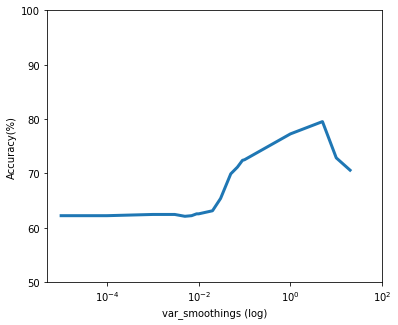

<Figure size 432x288 with 0 Axes>

In [ ]:
# Naive Bayes parameter tuning
accuracy = []
var_smoothings = [20, 10, 5, 1, 0.1, 9e-2, 7e-2, 5e-2, 3e-2, 2e-2, 1e-2, 9e-3, 7e-3, 5e-3, 3e-3, 1e-3, 1e-4, 1e-5]
for var in var_smoothings:
    gnb = GaussianNB(var_smoothing = var).fit(xtrain, ytrain) 
    tmp = gnb.score(xtest, ytest)  
    accuracy.append(tmp)

plt.figure(figsize = (6, 5))
ax = plt.plot(var_smoothings, np.array(accuracy)*100, linewidth=3)
plt.ylabel("Accuracy(%)")
plt.xlabel("var_smoothings (log)")
plt.xscale('log') 
plt.ylim([50, 100])
plt.xlim([0.000005, 100])
plt.rcParams.update({'font.size': 14})
plt.show()
plt.savefig('NB_parameter_tuning.png', bbox_inches = 'tight')

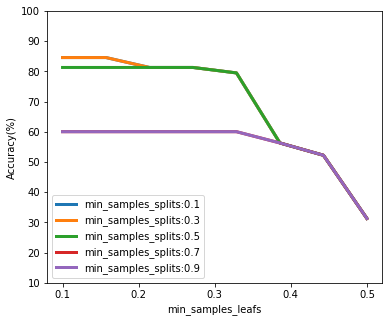

<Figure size 432x288 with 0 Axes>

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

min_samples_splits = [0.1, 0.3, 0.5, 0.7, 0.9]
min_samples_leafs  = np.linspace(0.1, 0.5, 8, endpoint=True)

accuracy = []
for split in min_samples_splits:
    tmp = []
    for numleaf in min_samples_leafs:
        classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0, 
                max_depth = 3, min_samples_leaf = numleaf, min_samples_split = split) 
        classifier.fit(xtrain, ytrain)
        ypred = classifier.predict(xtest)
        res = accuracy_score(ytest, ypred)
        tmp.append(res)
    accuracy.append(tmp)

results = []
results.append(min_samples_splits)
results.append(min_samples_leafs)
results.append(accuracy)

plt.figure(figsize = (6, 5))
for i in range(len(min_samples_splits)):
    acc = np.array(accuracy[i]) * 100
    plt.plot(min_samples_leafs, acc, label="min_samples_splits:" +str(min_samples_splits[i]), linewidth=3)
plt.legend()
plt.ylim([10, 100])
plt.ylabel("Accuracy(%)")
plt.xlabel("min_samples_leafs")
plt.rcParams.update({'font.size': 14})
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()
plt.savefig('decisiontree_parameter_tuning.png', bbox_inches = 'tight')


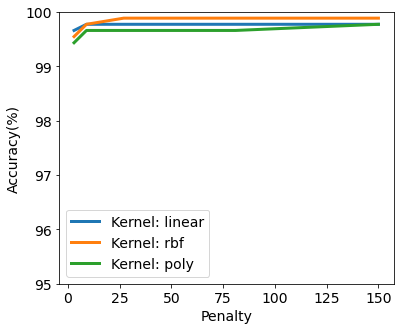

<Figure size 432x288 with 0 Axes>

In [ ]:
# SVM parameter tuning
C =  [3, 9, 27, 54, 81, 150]
gammas = ['scale', 'auto']  #the results shows 'auto' gamma is really bad, we should use scale
kernels = ['linear', 'rbf', 'poly']
accuracy = []
for k in kernels:
    tmp = []
    for c in C:
        svm_model = SVC(kernel = k, C = c).fit(xtrain, ytrain)    
        res = svm_model.score(xtest, ytest) 
        tmp.append(res)
    accuracy.append(tmp)

plt.figure(figsize = (6, 5))
for i in range(len(kernels)):
    acc = np.array(accuracy[i]) * 100
    plt.plot(C, acc, label="Kernel: " + str(kernels[i]), linewidth=3)
plt.legend()
plt.ylim([95, 100])
plt.ylabel("Accuracy(%)")
plt.xlabel("Penalty")
plt.show()
plt.savefig('SVM_parameter_tuning.png', bbox_inches = 'tight')

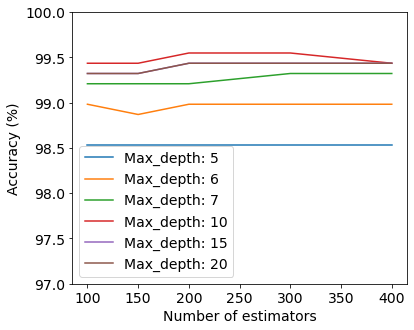

<Figure size 432x288 with 0 Axes>

In [ ]:
# Random forest

n_estimators = [100, 150, 200, 300, 400]
max_features = 2
max_depth = [5, 6, 7, 10, 15, 20]

accuracy = []
for d in max_depth:
    tmp = []
    for est in n_estimators:
        randomForest = RandomForestClassifier(n_estimators=est, max_depth =d, random_state=0)
        randomForest.fit(xtrain, ytrain)
        ypred = randomForest.predict(xtest)  
        res = metrics.accuracy_score(ytest, ypred)
        tmp.append(res)
    accuracy.append(tmp)

    
plt.figure(figsize = (6, 5))
for i in range(len(max_depth)):
    acc = np.array(accuracy[i]) * 100
    plt.plot(n_estimators, acc, label="Max_depth: " + str(max_depth[i]))
plt.legend()
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of estimators")
plt.ylim([97, 100])
plt.rcParams.update({'font.size': 14})
plt.show()
plt.savefig('randomForest_parameter_tuning.png', bbox_inches = 'tight')

In [ ]:
# KNN parameter optimization
accuracy = []
neighbors = range(4, 100, 3)
for i in range(4):
    tmp = []
    for n_neigh in neighbors:
        dist_order = i + 1
        classifier = KNeighborsClassifier(n_neighbors=n_neigh, p = dist_order)
        classifier.fit(xtrain, ytrain)
        ypred = classifier.predict(xtest)
        res = accuracy_score(ytest, ypred)
        tmp.append(res)
    accuracy.append(tmp)
results = []
results.append(neighbors)
results.append(accuracy)

torch.save(results, 'KNN_parameter_tuning')


accs = torch.load('KNN_parameter_tuning_20220113')
neighbors, accuracy = accs

plt.figure(figsize=(6, 5))
for i in range(4):
    acc = np.array(accuracy[i]) * 100
    plt.plot(neighbors, acc, label="Distance_order: " + str(i + 1), linewidth = 3)
plt.legend()
plt.ylim([90, 100])
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of neighbors")
plt.rcParams.update({'font.size': 14})
plt.show()